# EDA

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')

### Load datasets

In [3]:
directory = "/Users/rnirms/Documents/omdena/data/CPCB_downloads/2023-03-07/csv_latest/"

all_files = os.listdir(directory)

# Filter the list to include only .xlsx files
csv_files = [file for file in all_files if file.endswith(".csv")]

# Print the list
print(csv_files)


['BandraKurlaComplexMumbaiIITM.csv', 'SiddharthNagarWorliMumbaiIITM.csv', 'BandraMumbaiMPCB.csv', 'BorivaliEastMumbaiIITM.csv', 'VasaiWestMumbaiMPCB.csv', 'KhindipadaBhandupWestMumbaiIITM.csv', 'NavyNagarColabaMumbaiIITM.csv', 'BorivaliEastMumbaiMPCB.csv', 'ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv', 'ChakalaAndheriEastMumbaiIITM.csv', 'WorliMumbaiMPCB.csv', 'SionMumbaiMPCB.csv', 'MaladWestMumbaiIITM.csv', 'VileParleWestMumbaiMPCB.csv', 'DeonarMumbaiIITM.csv', 'PowaiMumbaiMPCB.csv', 'ColabaMumbaiMPCB.csv', 'KandivaliEastMumbaiMPCB.csv', 'MazgaonMumbaiIITM.csv', 'MulundWestMumbaiMPCB.csv', 'KurlaMumbaiMPCB.csv']


### Get single station data (Worli)

In [4]:
df = pd.read_csv(os.path.join(directory, csv_files[-1]))
df.head()

,Unnamed: 0,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,...,Eth-Benzene,MP-Xylene,RH,WS,WD,SR,BP,AT,TOT-RF,Unnamed: 23
0,1,01-01-2021 00:00,01-01-2021 00:15,150,330.21,92.03,25.09,117.14,38.31,37.22,...,23.3,0.59,68.43,0.59,156.02,None,None,23.1,0,NaN
1,2,01-01-2021 00:15,01-01-2021 00:30,150,398,101.03,23.89,124.94,37.9,38.6,...,21.85,0.68,69.3,0.5,189.3,None,None,22.74,0,NaN
2,3,01-01-2021 00:30,01-01-2021 00:45,150,398,113.79,22.28,136.06,36.74,40.23,...,31.43,None,71.45,0.49,238.31,None,None,22.77,0,NaN
3,4,01-01-2021 00:45,01-01-2021 01:00,164.42,398,126.27,22.24,148.53,28.61,36.52,...,27.64,11.98,76.18,0.73,292.77,None,None,22.53,0,NaN
4,5,01-01-2021 01:00,01-01-2021 01:15,209,459.16,131.9,22.61,154.51,24.13,33.75,...,11.9,32.39,80.07,0.53,248.84,None,None,22.19,0,NaN


Remove columns: Unnamed:0, From Date, Unnamed:23

In [5]:
df = df.iloc[:, 2:-1]

In [6]:
df.columns

Index(['To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'TOT-RF'],
      dtype='object')

Check datatypes.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76321 entries, 0 to 76320
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   To Date      76321 non-null  object
 1   PM2.5        76321 non-null  object
 2   PM10         76321 non-null  object
 3   NO           76321 non-null  object
 4   NO2          76321 non-null  object
 5   NOx          76321 non-null  object
 6   NH3          76321 non-null  object
 7   SO2          76321 non-null  object
 8   CO           76321 non-null  object
 9   Ozone        76321 non-null  object
 10  Benzene      76321 non-null  object
 11  Toluene      76321 non-null  object
 12  Eth-Benzene  76321 non-null  object
 13  MP-Xylene    76321 non-null  object
 14  RH           76321 non-null  object
 15  WS           76321 non-null  object
 16  WD           76321 non-null  object
 17  SR           76321 non-null  object
 18  BP           76321 non-null  object
 19  AT           76321 non-nu

Convert date to `datetime` format. 

In [8]:
df = df.rename(columns={'To Date': 'Date'}) # Rename date column
df["Date"] = pd.to_datetime(df.Date, format='%d-%m-%Y %H:%M')

In [9]:
df.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,Toluene,Eth-Benzene,MP-Xylene,RH,WS,WD,SR,BP,AT,TOT-RF
0,2021-01-01 00:15:00,150,330.21,92.03,25.09,117.14,38.31,37.22,2.61,6.09,...,None,23.3,0.59,68.43,0.59,156.02,None,None,23.1,0
1,2021-01-01 00:30:00,150,398,101.03,23.89,124.94,37.9,38.6,2.37,2.39,...,None,21.85,0.68,69.3,0.5,189.3,None,None,22.74,0
2,2021-01-01 00:45:00,150,398,113.79,22.28,136.06,36.74,40.23,2.38,7.27,...,None,31.43,None,71.45,0.49,238.31,None,None,22.77,0
3,2021-01-01 01:00:00,164.42,398,126.27,22.24,148.53,28.61,36.52,2.16,5.37,...,None,27.64,11.98,76.18,0.73,292.77,None,None,22.53,0
4,2021-01-01 01:15:00,209,459.16,131.9,22.61,154.51,24.13,33.75,1.78,2.4,...,None,11.9,32.39,80.07,0.53,248.84,None,None,22.19,0


Convert other columns to `float`. 

In [10]:
df = df.replace('None', np.NaN)
df[df.columns[1:]] = df[df.columns[1:]].astype(float)

### Check missing values

In [11]:
begin_date = list(df['Date'])[0]
end_date = list(df['Date'])[-1]
print(f'Data date range: {begin_date} to {end_date}')

Data date range: 2021-01-01 00:15:00 to 2023-03-07 00:00:00


What should be the total number of rows in this dataset?

In [12]:
n_per_hour = 4
n_per_day = n_per_hour * 24
days = (365 + 366 + (30+28+6)) 
total_rows = days * n_per_day + 1 # 1 extra entry for 2023-03-07 00:00:00
total_rows

76321

In [13]:
len(df)

76321

In [14]:
missing_values = 100 * df.isnull().sum()/len(df)
print(missing_values)

Date             0.000000
PM2.5           29.335307
PM10            40.152776
NO              27.512742
NO2             31.193250
NOx             27.335858
NH3             28.927818
SO2             35.038849
CO              34.018160
Ozone           35.096500
Benzene         24.256758
Toluene        100.000000
Eth-Benzene     30.975747
MP-Xylene       31.004573
RH              28.633011
WS              28.633011
WD              28.633011
SR              65.224512
BP              73.794893
AT              28.845272
TOT-RF           0.000000
dtype: float64


Where is the 30% of missing values for PM2.5?

<AxesSubplot: >

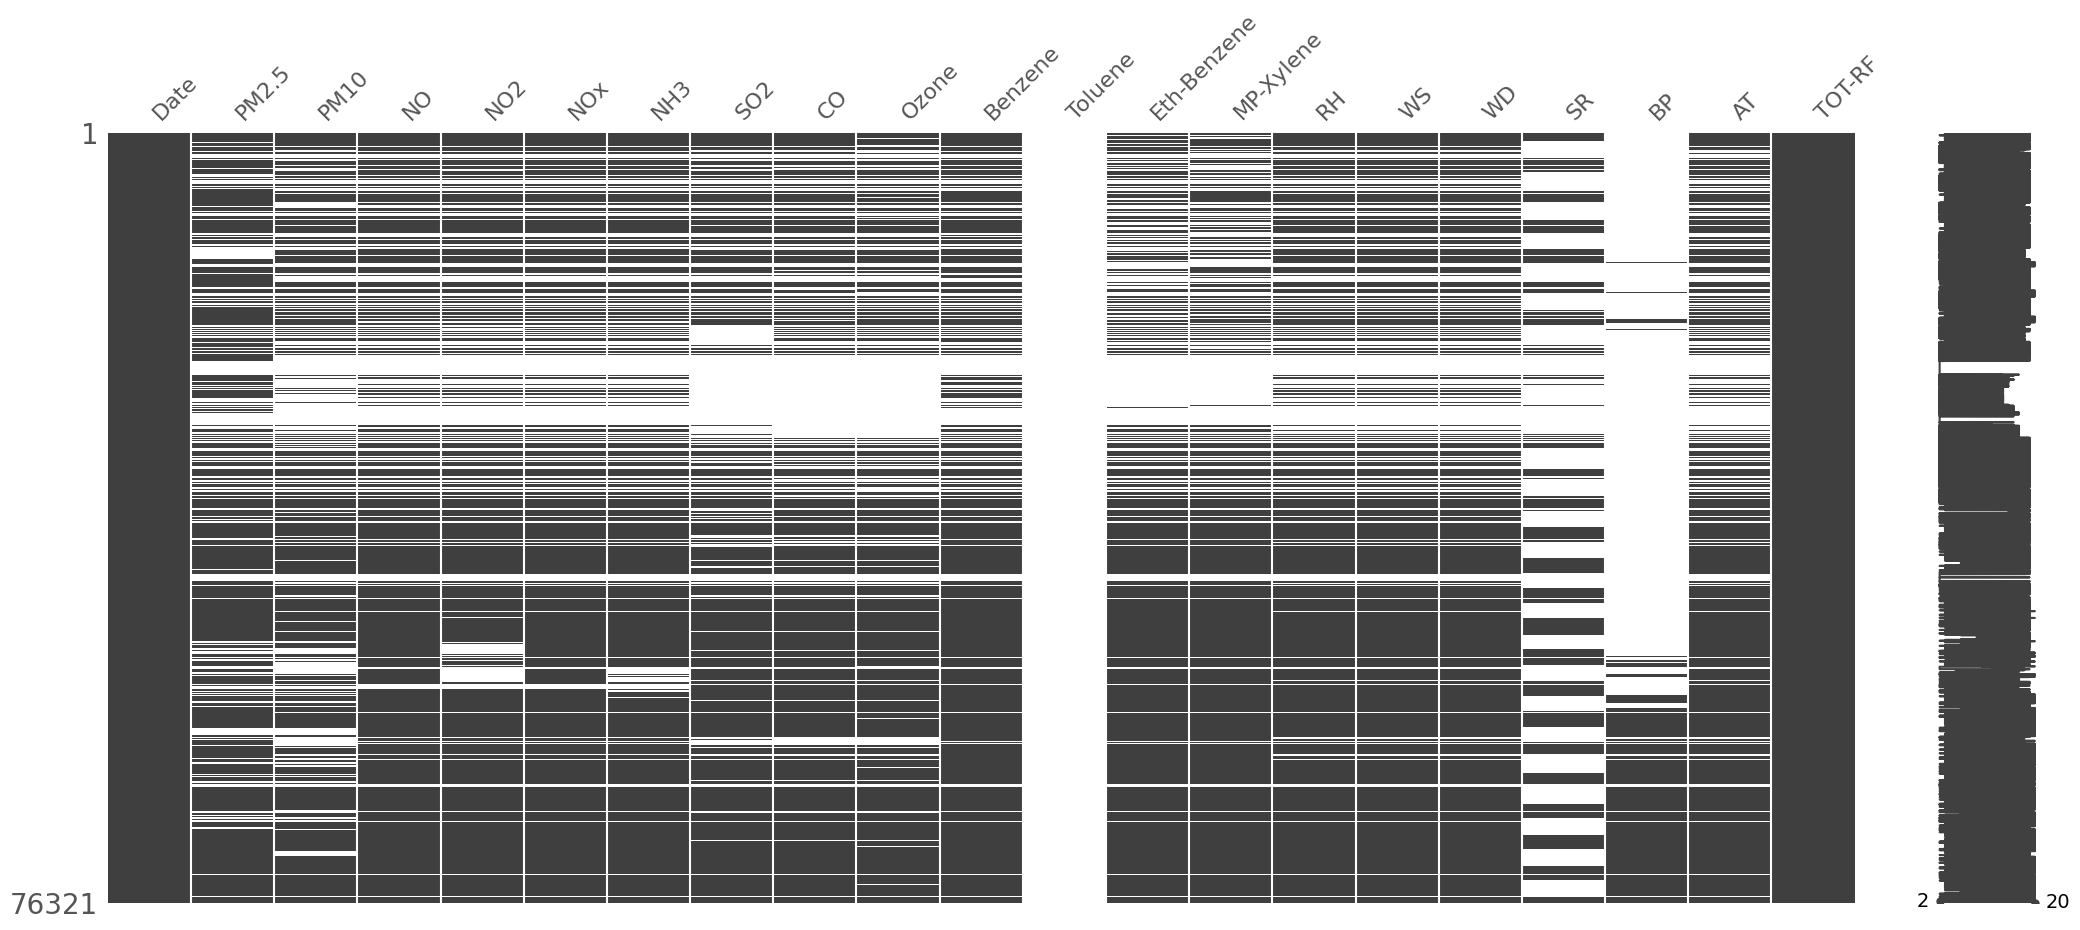

In [15]:
plt.rcParams['figure.figsize']=(16,6)
import missingno as msno
msno.matrix(df)

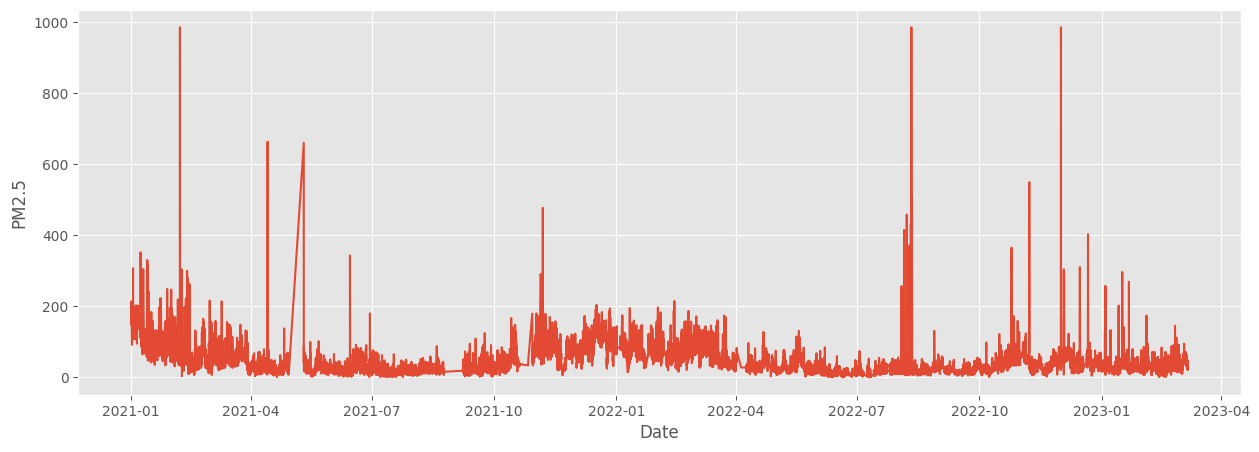

In [16]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 5))
 
# drawing the plot
# Plot the responses for different events and regions

graph = sns.lineplot(x="Date", y="PM2.5", ax=ax, data=df)


TO DO: 
* Missing data: 
    * Characterise type of missing data - entire station down OR only 1 sensor down OR down for 1 reading OR sensor down for a long period
* Outliers: 
    * Why are maximum values above 500 for PM2.5? 
    * Show box plots for each pollutant across stations 